# Day 3: EDA & Visualization

Exploratory Data Analysis on cleaned dataset to understand data characteristics before vectorization.

**Goals:**
1. Visualize key distributions (skills, industries, salary, location)
2. Identify patterns and correlations
3. Generate insights for modeling decisions
4. Create publication-quality figures

**Dataset:** `data/processed/clean_jobs.parquet` (123,842 jobs, 64 columns)

In [1]:
from pathlib import Path
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from IPython.display import display

# Suppress warnings
warnings.filterwarnings('ignore')

# Configure visualization
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 20)

# Directories
project_root = (Path.cwd() / '..').resolve()
data_dir = project_root / 'data'
images_dir = project_root / 'images'
reports_dir = project_root / 'reports'
images_dir.mkdir(exist_ok=True)
reports_dir.mkdir(exist_ok=True)

print(f'Project root: {project_root}')
print(f'Images will be saved to: {images_dir}')
print(f'Reports will be saved to: {reports_dir}')

Project root: /home/sakana/Code/DS-RS
Images will be saved to: /home/sakana/Code/DS-RS/images
Reports will be saved to: /home/sakana/Code/DS-RS/reports


## Load Cleaned Dataset

In [2]:
print('Loading cleaned dataset...')
df = pd.read_parquet(data_dir / 'processed' / 'clean_jobs.parquet')

print(f'\n{'='*80}')
print('DATASET OVERVIEW')
print('='*80)
print(f'Shape: {df.shape}')
print(f'Memory usage: {df.memory_usage(deep=True).sum() / 1e9:.2f} GB')
print(f'\nColumns: {len(df.columns)}')

# Key fields completeness
print(f'\nKey fields completeness:')
for col in ['content', 'skills', 'industries', 'city', 'country', 'work_type', 'normalized_salary']:
    if col in df.columns:
        pct = (df[col].notna().sum() / len(df)) * 100
        print(f'  {col:20}: {df[col].notna().sum():>7,} ({pct:>5.1f}%)')

# Content statistics
if 'content' in df.columns:
    print(f'\nContent statistics:')
    print(f'  Avg length: {df["content"].str.len().mean():.0f} chars')
    print(f'  Min length: {df["content"].str.len().min():.0f} chars')
    print(f'  Max length: {df["content"].str.len().max():.0f} chars')

# Display sample
display(df.head())

Loading cleaned dataset...

DATASET OVERVIEW
Shape: (123842, 64)
Memory usage: 2.24 GB

Columns: 64

Key fields completeness:
  content             : 123,842 (100.0%)
  skills              : 122,090 ( 98.6%)
  industries          : 122,308 ( 98.8%)
  city                : 110,481 ( 89.2%)
  country             : 123,842 (100.0%)
  work_type           : 123,842 (100.0%)
  normalized_salary   :   6,280 (  5.1%)

Content statistics:
  Avg length: 3725 chars
  Min length: 15 chars
  Max length: 22711 chars


,job_id,company_name_x,title,description,max_salary,pay_period,location,company_id,views,med_salary,min_salary,formatted_work_type,applies,original_listed_time,remote_allowed,job_posting_url,application_url,application_type,expiry,closed_time,formatted_experience_level,skills_desc,listed_time,posting_domain,sponsored,...,salary_type,company_name_y,company_description,company_size,company_state,company_country,company_city,company_zip,company_url,company_specialities,company_industries,company_employee_count,company_follower_count,time_recorded,title_clean,description_clean,skills_desc_clean,content,city,state,country,experience_level,has_salary_info,has_remote_flag,is_remote
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458,20,NaN,17.0,Full-time,2,1.713398e+12,<NA>,https://www.linkedin.com/jobs/view/921716/?trk...,None,ComplexOnsiteApply,1.715990e+12,NaN,NaN,Requirements: \n\nWe are seeking a College or ...,1.713398e+12,None,0,...,BASE_SALARY,Corcoran Sawyer Smith,With years of experience helping local buyers ...,2.0,NJ,US,Jersey City,07302,https://www.linkedin.com/company/corcoran-sawy...,"new development, real estate",Real Estate,402.0,2351.0,1.713409e+09,marketing coordinator,job descriptiona leading real estate firm in n...,requirements we are seeking a college or gradu...,marketing coordinator marketing coordinator jo...,Princeton,NJ,United States,Unknown,1,0,0
1,1829192,None,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",50.0,HOURLY,"Fort Collins, CO",<NA>,1,NaN,30.0,Full-time,<NA>,1.712858e+12,<NA>,https://www.linkedin.com/jobs/view/1829192/?tr...,None,ComplexOnsiteApply,1.715450e+12,NaN,NaN,None,1.712858e+12,None,0,...,BASE_SALARY,None,None,NaN,None,None,None,None,None,None,None,NaN,NaN,NaN,mental health therapist counselor,at aspen therapy and wellness we are committed...,,mental health therapist counselor mental healt...,Fort Collins,CO,United States,Unknown,1,0,0
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,YEARLY,"Cincinnati, OH",64896719,8,NaN,45000.0,Full-time,<NA>,1.713278e+12,<NA>,https://www.linkedin.com/jobs/view/10998357/?t...,None,ComplexOnsiteApply,1.715870e+12,NaN,NaN,We are currently accepting resumes for FOH - A...,1.713278e+12,None,0,...,BASE_SALARY,The National Exemplar,"In April of 1983, The National Exemplar began ...",1.0,Ohio,US,Mariemont,45227,https://www.linkedin.com/company/the-national-...,None,Restaurants,15.0,40.0,1.713279e+09,assitant restaurant manager,the national exemplar is accepting application...,we are currently accepting resumes for foh asi...,assitant restaurant manager assitant restauran...,Cincinnati,OH,United States,Unknown,1,0,0
3,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,175000.0,YEARLY,"New Hyde Park, NY",766262,16,NaN,140000.0,Full-time,<NA>,1.712896e+12,<NA>,https://www.linkedin.com/jobs/view/23221523/?t...,None,ComplexOnsiteApply,1.715488e+12,NaN,NaN,This position requires a baseline understandin...,1.712896e+12,None,0,...,BASE_SALARY,"Abrams Fensterman, LLP","Abrams Fensterman, LLP is a full-service law f...",2.0,New York,US,Lake Success,11042,https://www.linkedin.com/company/abrams-fenste...,"Appellate, Civil Litigation, Corporate & Secur...",Law Practice,222.0,2427.0,1.712897e+09,senior elder law trusts and estates associate ...,senior associate attorney elder law trusts and...,this position requires a baseline understandin...,senior elder law trusts and estates associate ...,New Hyde Park,NY,United States,Unknown,1,0,0
4,35982263,None,Service Technician,Looking for HVAC service tech with experience ...,80000.0,YEARLY,"Burlington, IA",<NA>,3,NaN,60000.0,Full-time,<NA>,1.713452e+12,<NA>,https://www.linkedin.com/jobs/view/35982263/?t...,None,ComplexOnsiteApply,1.716044e+12,NaN,NaN,No

## 1. Skills Analysis

Analyze the most in-demand skills across all job postings.

In [3]:
# Extract all skills (skills are comma-separated)
skills_series = df['skills'].dropna()
all_skills = []
for skills_str in skills_series:
    if isinstance(skills_str, str):
        skills_list = [s.strip() for s in skills_str.split(',')]
        all_skills.extend(skills_list)

# Count frequency
from collections import Counter
skills_counter = Counter(all_skills)
top_20_skills = pd.DataFrame(skills_counter.most_common(20), columns=['Skill', 'Count'])

print(f'Total unique skills: {len(skills_counter):,}')
print(f'Total skill mentions: {len(all_skills):,}')
print(f'\nTop 20 Skills:')
display(top_20_skills)

Total unique skills: 35
Total skill mentions: 205,767

Top 20 Skills:


,Skill,Count
0,Information Technology,25255
1,Sales,21190
2,Management,20385
3,Manufacturing,17728
4,Health Care Provider,16675
5,Business Development,13303
6,Engineering,12530
7,Other,12313
8,Finance,8009
9,Marketing,5399


✓ Saved to /home/sakana/Code/DS-RS/images/eda_skills_analysis.png


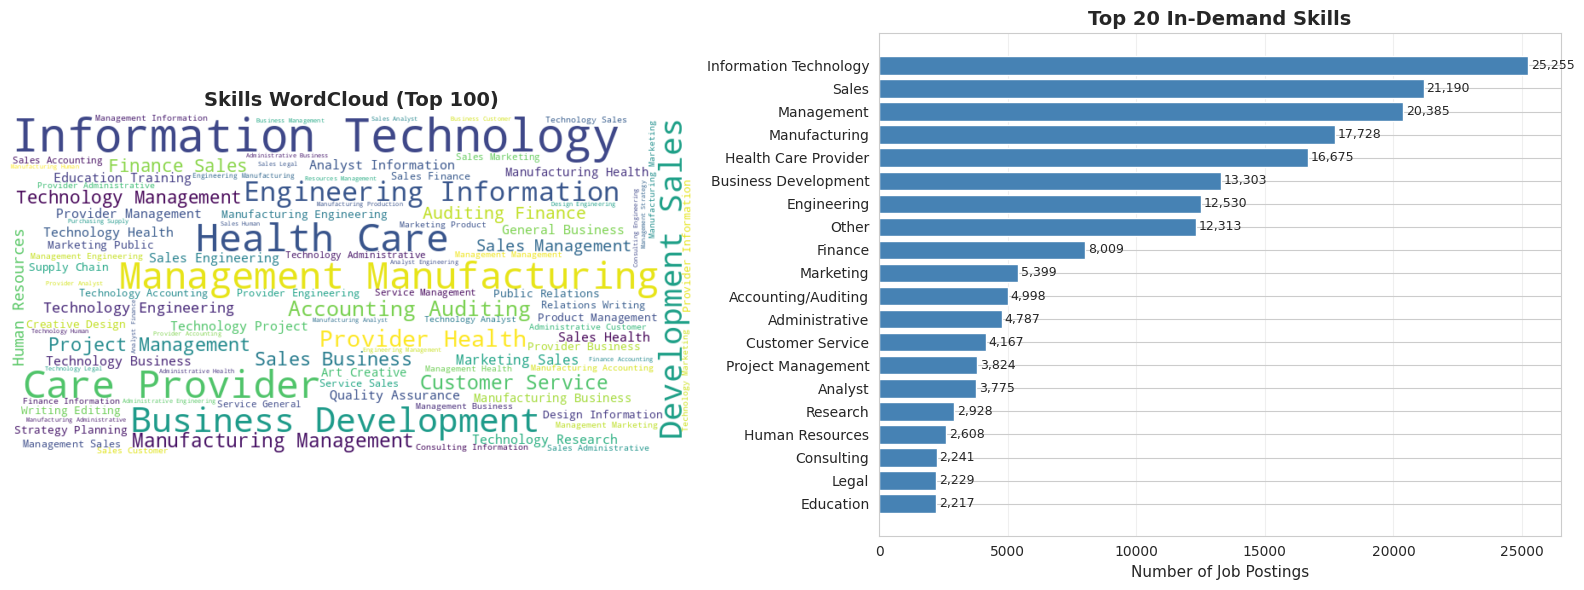

In [4]:
# Create WordCloud for skills
skills_text = ' '.join(all_skills)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# WordCloud
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white',
    colormap='viridis',
    max_words=100
).generate(skills_text)

axes[0].imshow(wordcloud, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Skills WordCloud (Top 100)', fontsize=14, fontweight='bold')

# Top 20 bar chart
axes[1].barh(range(len(top_20_skills)), top_20_skills['Count'], color='steelblue')
axes[1].set_yticks(range(len(top_20_skills)))
axes[1].set_yticklabels(top_20_skills['Skill'])
axes[1].set_xlabel('Number of Job Postings', fontsize=11)
axes[1].set_title('Top 20 In-Demand Skills', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

for i, count in enumerate(top_20_skills['Count']):
    axes[1].text(count + 100, i, f'{count:,}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(images_dir / 'eda_skills_analysis.png', dpi=150, bbox_inches='tight')
print(f'✓ Saved to {images_dir / "eda_skills_analysis.png"}')
plt.show()

## 2. Industry & Work Type Distribution

Analyze job distribution across industries and work types.

✓ Saved to /home/sakana/Code/DS-RS/images/eda_industry_worktype.png


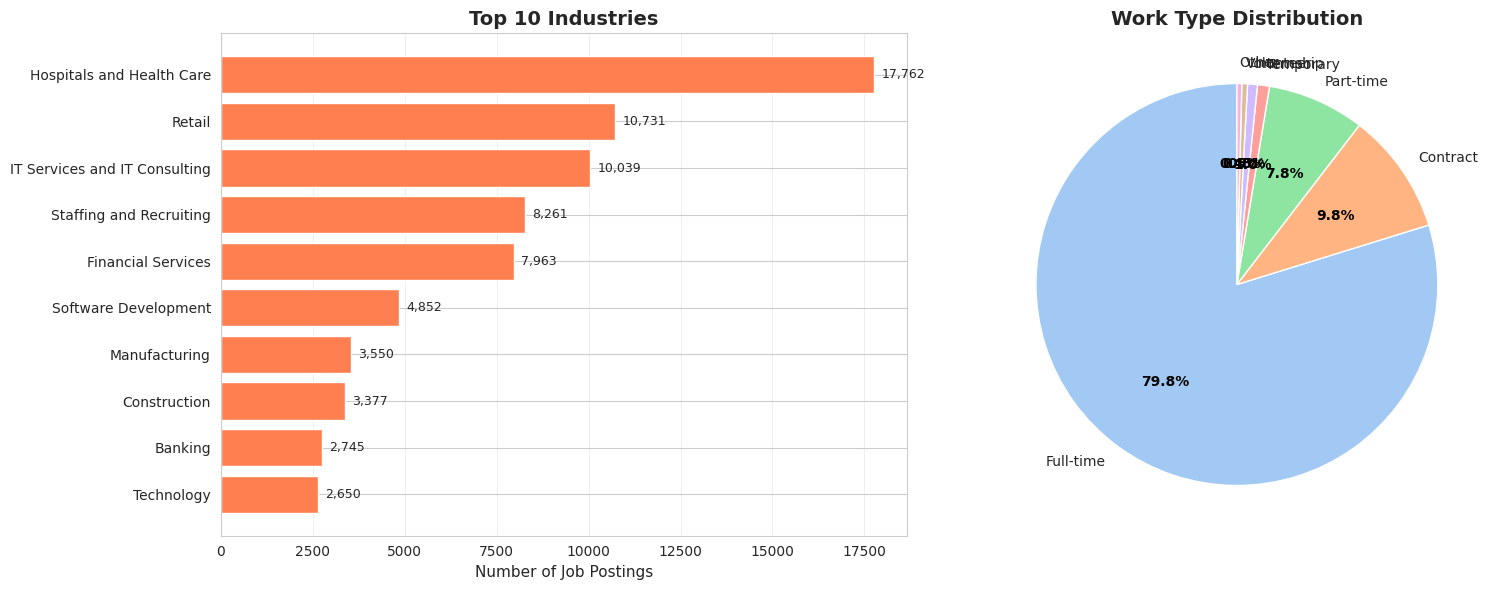


Top 10 Industries:


,Industry,Count
0,Hospitals and Health Care,17762
1,Retail,10731
2,IT Services and IT Consulting,10039
3,Staffing and Recruiting,8261
4,Financial Services,7963
5,Software Development,4852
6,Manufacturing,3550
7,Construction,3377
8,Banking,2745
9,Technology,2650



Work Type Distribution:


,Count
work_type,
Full-time,98807
Contract,12117
Part-time,9696
Temporary,1190
Internship,983
Volunteer,562
Other,487


In [5]:
# Extract industries (comma-separated like skills)
industries_series = df['industries'].dropna()
all_industries = []
for ind_str in industries_series:
    if isinstance(ind_str, str):
        industries_list = [i.strip() for i in ind_str.split(',')]
        all_industries.extend(industries_list)

industries_counter = Counter(all_industries)
top_10_industries = pd.DataFrame(industries_counter.most_common(10), columns=['Industry', 'Count'])

# Work type distribution
work_type_dist = df['work_type'].value_counts().head(8)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 10 industries
axes[0].barh(range(len(top_10_industries)), top_10_industries['Count'], color='coral')
axes[0].set_yticks(range(len(top_10_industries)))
axes[0].set_yticklabels(top_10_industries['Industry'])
axes[0].set_xlabel('Number of Job Postings', fontsize=11)
axes[0].set_title('Top 10 Industries', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

for i, count in enumerate(top_10_industries['Count']):
    axes[0].text(count + 200, i, f'{count:,}', va='center', fontsize=9)

# Work type pie chart
colors = sns.color_palette('pastel', len(work_type_dist))
wedges, texts, autotexts = axes[1].pie(
    work_type_dist.values, 
    labels=work_type_dist.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors
)
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(10)
    autotext.set_fontweight('bold')
axes[1].set_title('Work Type Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(images_dir / 'eda_industry_worktype.png', dpi=150, bbox_inches='tight')
print(f'✓ Saved to {images_dir / "eda_industry_worktype.png"}')
plt.show()

print(f'\nTop 10 Industries:')
display(top_10_industries)
print(f'\nWork Type Distribution:')
display(work_type_dist.to_frame('Count'))

## 3. Salary Analysis

Analyze salary distribution and compensation patterns.

In [6]:
# Filter salary data (remove outliers using 99th percentile)
salary_data = df[df['normalized_salary'].notna()].copy()
q99 = salary_data['normalized_salary'].quantile(0.99)
q1 = salary_data['normalized_salary'].quantile(0.01)
salary_filtered = salary_data[(salary_data['normalized_salary'] <= q99) & 
                               (salary_data['normalized_salary'] >= q1)]

print(f'Jobs with salary info: {len(salary_data):,} ({len(salary_data)/len(df)*100:.1f}%)')
print(f'After filtering outliers: {len(salary_filtered):,}')
print(f'\nSalary Statistics (yearly, USD):')
print(f'  Mean:   ${salary_filtered["normalized_salary"].mean():,.0f}')
print(f'  Median: ${salary_filtered["normalized_salary"].median():,.0f}')
print(f'  Min:    ${salary_filtered["normalized_salary"].min():,.0f}')
print(f'  Max:    ${salary_filtered["normalized_salary"].max():,.0f}')

Jobs with salary info: 6,280 (5.1%)
After filtering outliers: 6,157

Salary Statistics (yearly, USD):
  Mean:   $61,647
  Median: $47,840
  Min:    $12,000
  Max:    $230,000


✓ Saved to /home/sakana/Code/DS-RS/images/eda_salary_distribution.png


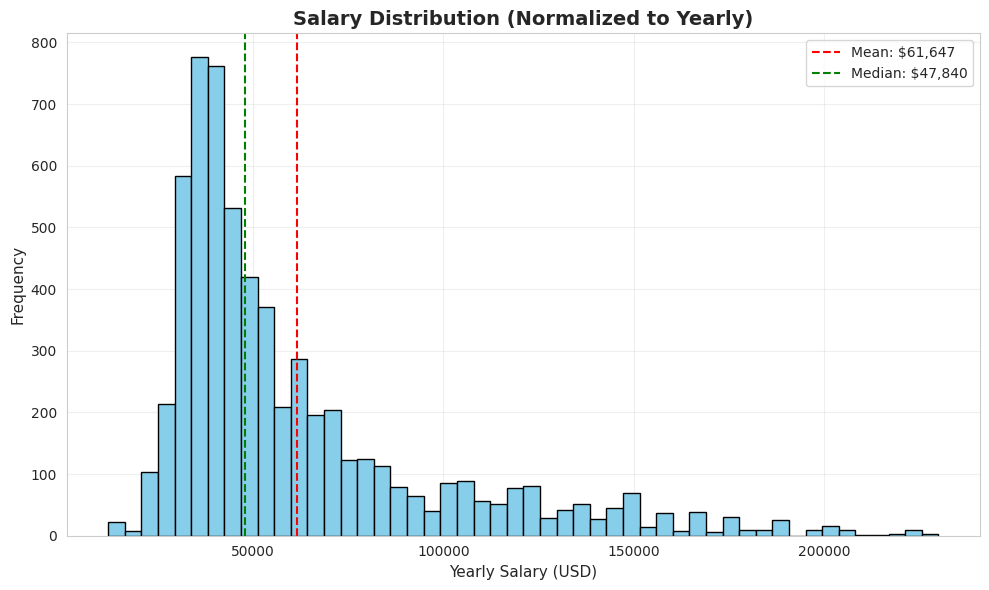

✓ Saved to /home/sakana/Code/DS-RS/images/eda_salary_by_work_type.png


<Figure size 1000x600 with 0 Axes>

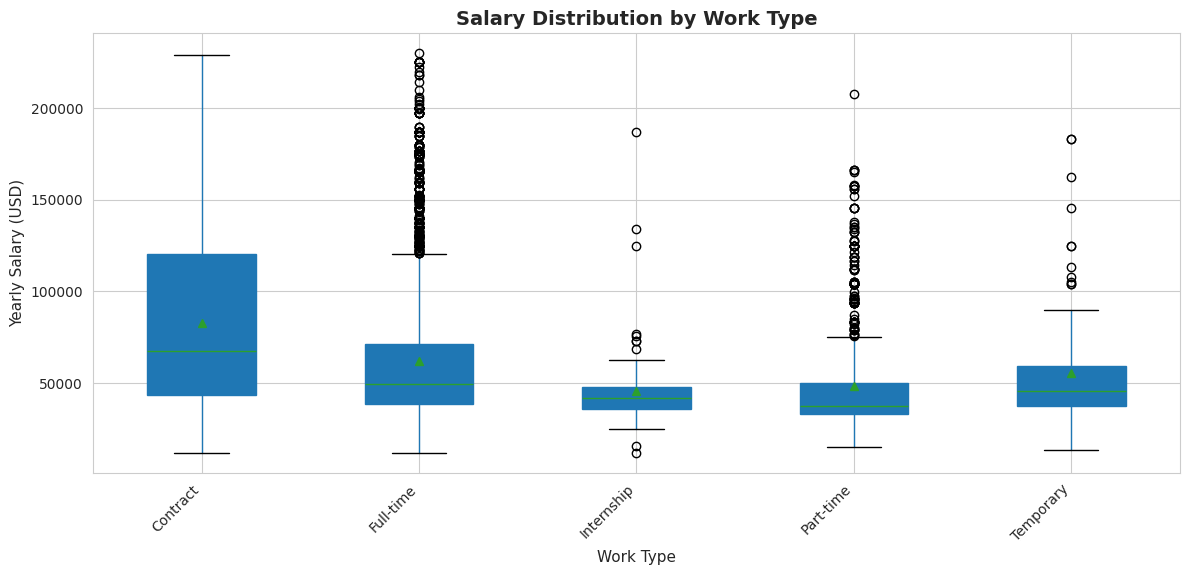

✓ Saved to /home/sakana/Code/DS-RS/images/eda_salary_by_experience.png


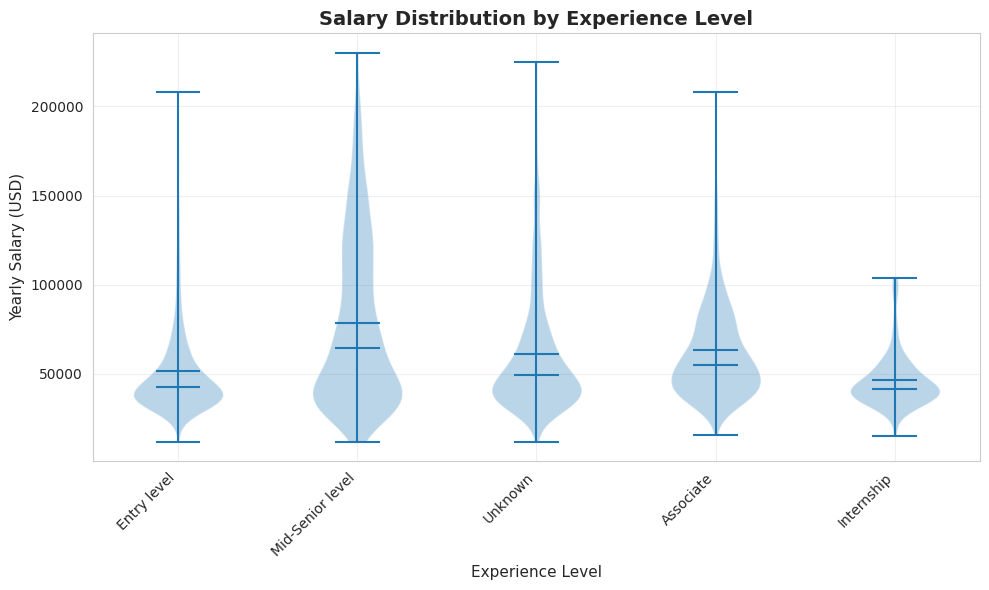

✓ Saved to /home/sakana/Code/DS-RS/images/eda_salary_by_industry.png


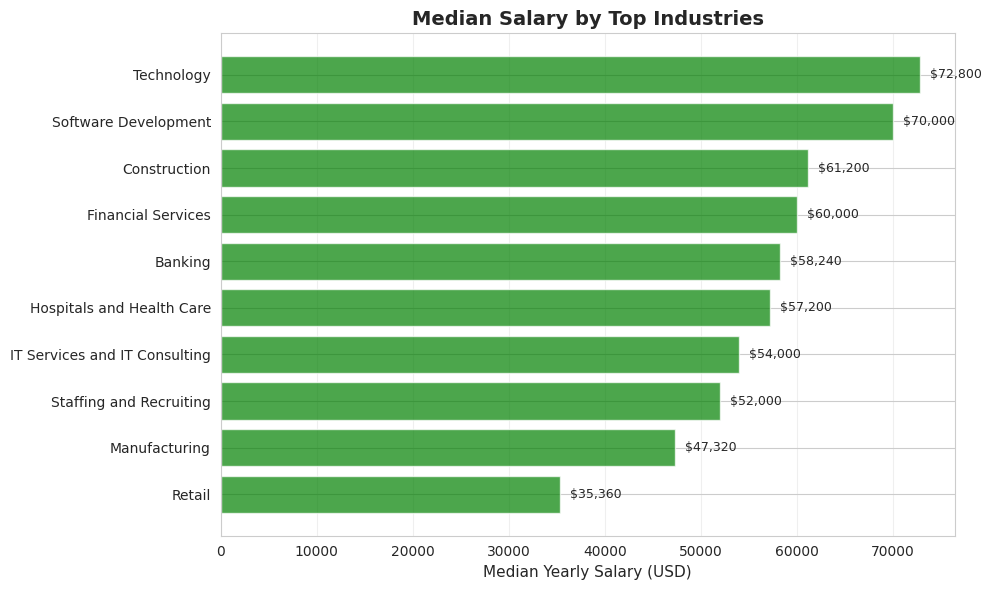

In [7]:
# 1. Salary distribution histogram
plt.figure(figsize=(10, 6))
plt.hist(salary_filtered['normalized_salary'], bins=50, edgecolor='black', color='skyblue')
plt.axvline(salary_filtered['normalized_salary'].mean(), color='red', linestyle='--', 
                   label=f'Mean: ${salary_filtered["normalized_salary"].mean():,.0f}')
plt.axvline(salary_filtered['normalized_salary'].median(), color='green', linestyle='--',
                   label=f'Median: ${salary_filtered["normalized_salary"].median():,.0f}')
plt.xlabel('Yearly Salary (USD)', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Salary Distribution (Normalized to Yearly)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(images_dir / 'eda_salary_distribution.png', dpi=150, bbox_inches='tight')
print(f'✓ Saved to {images_dir / "eda_salary_distribution.png"}')
plt.show()

# 2. Salary by work type boxplot
plt.figure(figsize=(10, 6))
work_types = salary_filtered['work_type'].value_counts().head(5).index
salary_by_work = salary_filtered[salary_filtered['work_type'].isin(work_types)]
salary_by_work.boxplot(column='normalized_salary', by='work_type', 
                        patch_artist=True, showmeans=True)
plt.xlabel('Work Type', fontsize=11)
plt.ylabel('Yearly Salary (USD)', fontsize=11)
plt.title('Salary Distribution by Work Type', fontsize=14, fontweight='bold')
plt.suptitle('')  # Remove auto title
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(images_dir / 'eda_salary_by_work_type.png', dpi=150, bbox_inches='tight')
print(f'✓ Saved to {images_dir / "eda_salary_by_work_type.png"}')
plt.show()

# 3. Salary by experience level (if available)
if 'experience_level' in salary_filtered.columns:
    plt.figure(figsize=(10, 6))
    exp_levels = salary_filtered['experience_level'].value_counts().head(5).index
    salary_by_exp = salary_filtered[salary_filtered['experience_level'].isin(exp_levels)]
    
    plt.violinplot(
        [salary_by_exp[salary_by_exp['experience_level'] == exp]['normalized_salary'].values 
         for exp in exp_levels],
        positions=range(len(exp_levels)),
        showmeans=True,
        showmedians=True
    )
    plt.xticks(range(len(exp_levels)), exp_levels, rotation=45, ha='right')
    plt.xlabel('Experience Level', fontsize=11)
    plt.ylabel('Yearly Salary (USD)', fontsize=11)
    plt.title('Salary Distribution by Experience Level', fontsize=14, fontweight='bold')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(images_dir / 'eda_salary_by_experience.png', dpi=150, bbox_inches='tight')
    print(f'✓ Saved to {images_dir / "eda_salary_by_experience.png"}')
    plt.show()

# 4. Top 10 industries by median salary
plt.figure(figsize=(10, 6))
top_industries_salary = []
for ind in top_10_industries['Industry']:
    jobs_in_ind = salary_filtered[salary_filtered['industries'].str.contains(ind, na=False)]
    if len(jobs_in_ind) > 10:  # At least 10 jobs
        median_sal = jobs_in_ind['normalized_salary'].median()
        top_industries_salary.append({'Industry': ind, 'Median_Salary': median_sal, 'Count': len(jobs_in_ind)})

ind_salary_df = pd.DataFrame(top_industries_salary).sort_values('Median_Salary', ascending=True)

plt.barh(range(len(ind_salary_df)), ind_salary_df['Median_Salary'], color='green', alpha=0.7)
plt.yticks(range(len(ind_salary_df)), ind_salary_df['Industry'])
plt.xlabel('Median Yearly Salary (USD)', fontsize=11)
plt.title('Median Salary by Top Industries', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

for i, salary in enumerate(ind_salary_df['Median_Salary']):
    plt.text(salary + 1000, i, f'${salary:,.0f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(images_dir / 'eda_salary_by_industry.png', dpi=150, bbox_inches='tight')
print(f'✓ Saved to {images_dir / "eda_salary_by_industry.png"}')
plt.show()

## 4. Location & Remote Work Analysis

Analyze geographic distribution and remote work patterns.

In [8]:
# Top cities
top_cities = df['city'].value_counts().head(15)

# Remote work statistics
remote_stats = df['is_remote'].value_counts()
remote_pct = (df['is_remote'].sum() / len(df)) * 100

print(f'Remote Jobs: {df["is_remote"].sum():,} ({remote_pct:.1f}%)')
print(f'On-site Jobs: {(~df["is_remote"].astype(bool)).sum():,} ({100-remote_pct:.1f}%)')
print(f'\nTop 15 Cities:')
display(top_cities.head(15).to_frame('Count'))

Remote Jobs: 15,243 (12.3%)
On-site Jobs: 108,599 (87.7%)

Top 15 Cities:


,Count
city,
New York,3403
Chicago,1836
Houston,1776
Dallas,1394
Atlanta,1369
Austin,1325
Boston,1202
Washington,1118
Los Angeles,1100


✓ Saved to /home/sakana/Code/DS-RS/images/eda_location_remote.png


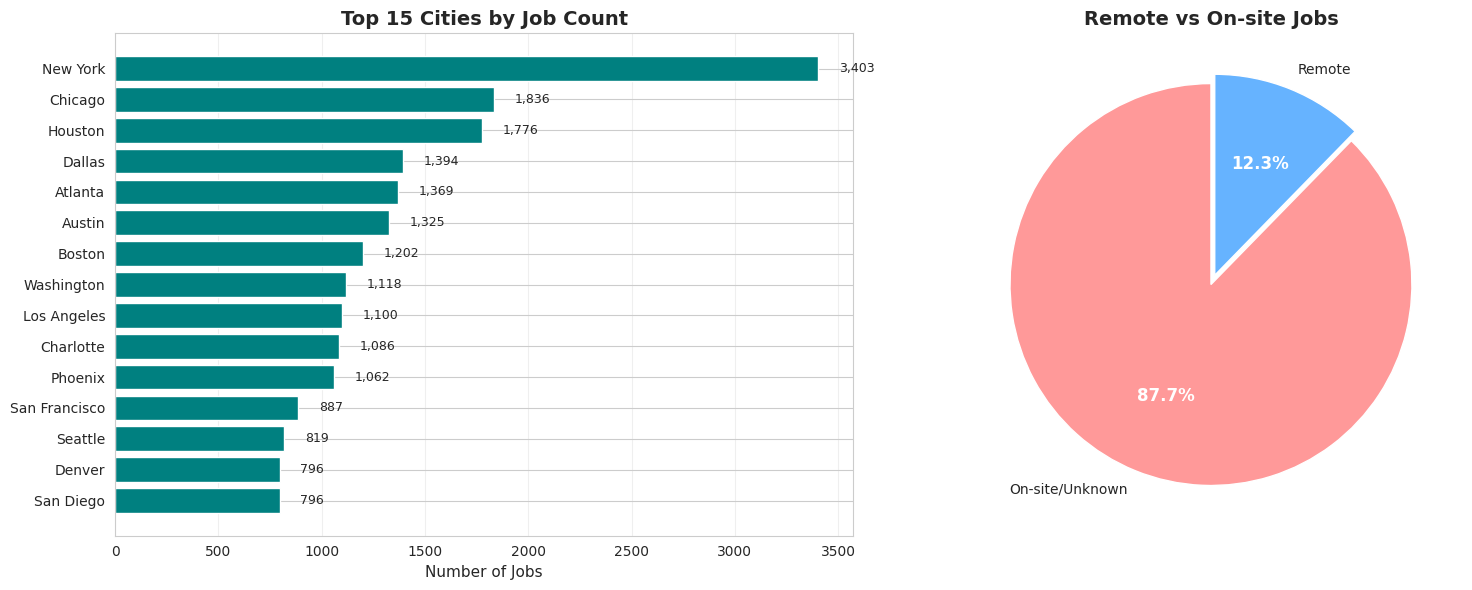

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 15 cities bar chart
axes[0].barh(range(len(top_cities)), top_cities.values, color='teal')
axes[0].set_yticks(range(len(top_cities)))
axes[0].set_yticklabels(top_cities.index)
axes[0].set_xlabel('Number of Jobs', fontsize=11)
axes[0].set_title('Top 15 Cities by Job Count', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

for i, count in enumerate(top_cities.values):
    axes[0].text(count + 100, i, f'{count:,}', va='center', fontsize=9)

# Remote vs On-site pie chart
remote_labels = ['On-site/Unknown', 'Remote']
remote_counts = [(~df['is_remote'].astype(bool)).sum(), df['is_remote'].sum()]
colors_remote = ['#ff9999', '#66b3ff']

wedges, texts, autotexts = axes[1].pie(
    remote_counts,
    labels=remote_labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors_remote,
    explode=(0, 0.05)
)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(12)
    autotext.set_fontweight('bold')
axes[1].set_title('Remote vs On-site Jobs', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(images_dir / 'eda_location_remote.png', dpi=150, bbox_inches='tight')
print(f'✓ Saved to {images_dir / "eda_location_remote.png"}')
plt.show()

## 5. Content Analysis

Analyze job description content characteristics.

In [10]:
# Content length statistics
df['content_length'] = df['content'].str.len()

print('Content Length Statistics:')
print(f'  Mean:   {df["content_length"].mean():.0f} characters')
print(f'  Median: {df["content_length"].median():.0f} characters')
print(f'  Min:    {df["content_length"].min():.0f} characters')
print(f'  Max:    {df["content_length"].max():.0f} characters')

# Average content length by top industries
content_by_industry = []
for ind in top_10_industries['Industry'].head(8):
    jobs_in_ind = df[df['industries'].str.contains(ind, na=False)]
    if len(jobs_in_ind) > 0:
        avg_len = jobs_in_ind['content_length'].mean()
        content_by_industry.append({'Industry': ind, 'Avg_Length': avg_len})

content_ind_df = pd.DataFrame(content_by_industry).sort_values('Avg_Length', ascending=True)

Content Length Statistics:
  Mean:   3725 characters
  Median: 3406 characters
  Min:    15 characters
  Max:    22711 characters


✓ Saved to /home/sakana/Code/DS-RS/images/eda_content_analysis.png


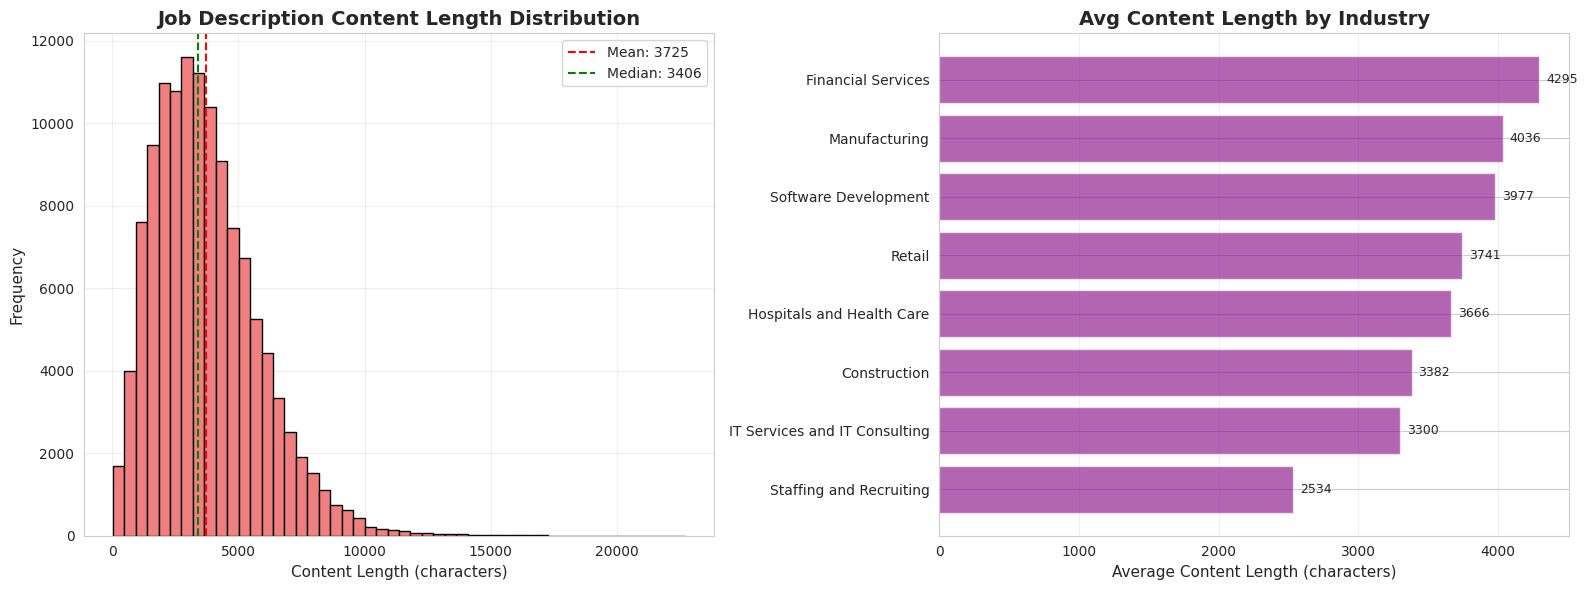

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Content length distribution
axes[0].hist(df['content_length'], bins=50, edgecolor='black', color='lightcoral')
axes[0].axvline(df['content_length'].mean(), color='red', linestyle='--',
                label=f'Mean: {df["content_length"].mean():.0f}')
axes[0].axvline(df['content_length'].median(), color='green', linestyle='--',
                label=f'Median: {df["content_length"].median():.0f}')
axes[0].set_xlabel('Content Length (characters)', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Job Description Content Length Distribution', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Average content length by industry
axes[1].barh(range(len(content_ind_df)), content_ind_df['Avg_Length'], color='purple', alpha=0.6)
axes[1].set_yticks(range(len(content_ind_df)))
axes[1].set_yticklabels(content_ind_df['Industry'])
axes[1].set_xlabel('Average Content Length (characters)', fontsize=11)
axes[1].set_title('Avg Content Length by Industry', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

for i, length in enumerate(content_ind_df['Avg_Length']):
    axes[1].text(length + 50, i, f'{length:.0f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(images_dir / 'eda_content_analysis.png', dpi=150, bbox_inches='tight')
print(f'✓ Saved to {images_dir / "eda_content_analysis.png"}')
plt.show()

## 6. Company Insights

Analyze top companies and company characteristics.

In [12]:
# Use company_name_y if available, fallback to company_name_x
company_col = 'company_name_y' if 'company_name_y' in df.columns else 'company_name_x'
top_companies = df[company_col].value_counts().head(20)

# Company size distribution
if 'company_size' in df.columns:
    company_size_dist = df['company_size'].value_counts().head(8)
else:
    company_size_dist = pd.Series()

print(f'Top 20 Companies by Job Postings:')
display(top_companies.to_frame('Job_Count'))

if not company_size_dist.empty:
    print(f'\nCompany Size Distribution:')
    display(company_size_dist.to_frame('Count'))

Top 20 Companies by Job Postings:


,Job_Count
company_name_y,
Liberty Healthcare and Rehabilitation Services,1108
The Job Network,1003
J. Galt,604
TEKsystems,529
"Lowe's Companies, Inc.",527
Ingersoll Rand,517
Capital One,496
Cogent Communications,476
Insight Global,418



Company Size Distribution:


,Count
company_size,
7.0,42779
5.0,22453
2.0,13388
6.0,11146
3.0,9358
1.0,9121
4.0,8894


✓ Saved to /home/sakana/Code/DS-RS/images/eda_company_insights.png


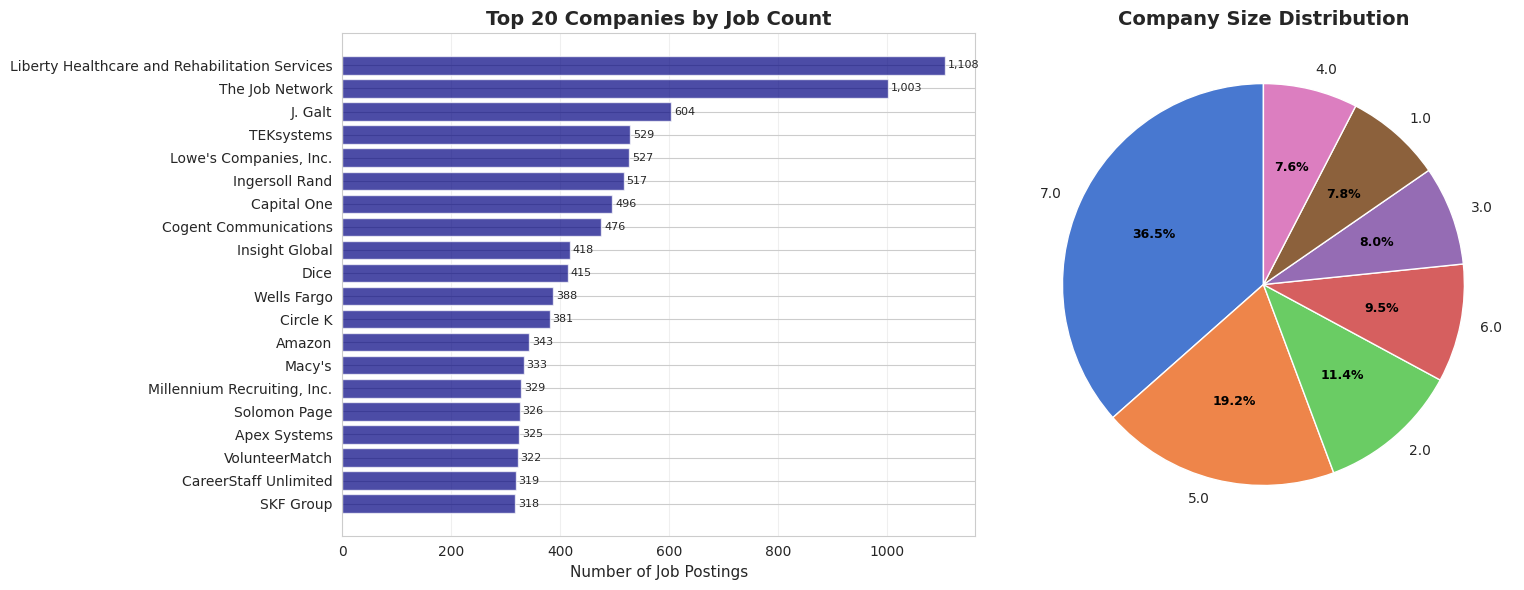

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 20 companies
axes[0].barh(range(len(top_companies)), top_companies.values, color='navy', alpha=0.7)
axes[0].set_yticks(range(len(top_companies)))
axes[0].set_yticklabels(top_companies.index)
axes[0].set_xlabel('Number of Job Postings', fontsize=11)
axes[0].set_title('Top 20 Companies by Job Count', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

for i, count in enumerate(top_companies.values):
    axes[0].text(count + 5, i, f'{count:,}', va='center', fontsize=8)

# Company size distribution
if not company_size_dist.empty:
    colors_size = sns.color_palette('muted', len(company_size_dist))
    wedges, texts, autotexts = axes[1].pie(
        company_size_dist.values,
        labels=company_size_dist.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=colors_size
    )
    for autotext in autotexts:
        autotext.set_color('black')
        autotext.set_fontsize(9)
        autotext.set_fontweight('bold')
    axes[1].set_title('Company Size Distribution', fontsize=14, fontweight='bold')
else:
    axes[1].text(0.5, 0.5, 'No company size data available', 
                 ha='center', va='center', fontsize=12)
    axes[1].set_xlim(0, 1)
    axes[1].set_ylim(0, 1)
    axes[1].axis('off')

plt.tight_layout()
plt.savefig(images_dir / 'eda_company_insights.png', dpi=150, bbox_inches='tight')
print(f'✓ Saved to {images_dir / "eda_company_insights.png"}')
plt.show()

## 8. Geographic Heatmap

Visualize job distribution across cities and work types.

✓ Saved to /home/sakana/Code/DS-RS/images/eda_city_worktype_heatmap.png


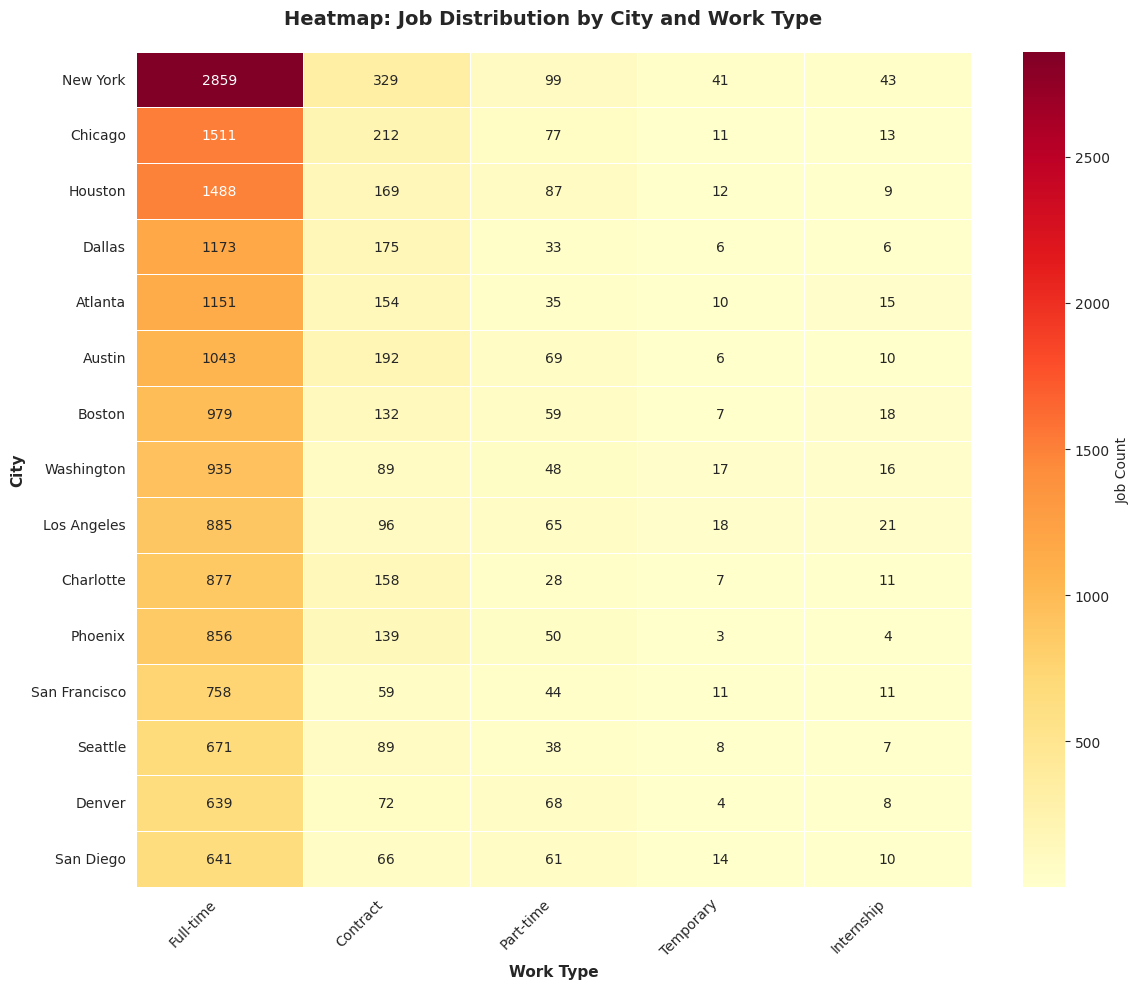


Heatmap Summary:
Cities analyzed: 15
Work types shown: 5
Total jobs in heatmap: 19,835


In [14]:
# Create pivot table: City x Work Type
pivot_data = df.groupby(['city', 'work_type']).size().unstack(fill_value=0)

# Get top 15 cities
top_15_cities = df['city'].value_counts().head(15).index
pivot_subset = pivot_data.loc[top_15_cities]

# Select top work types for cleaner visualization
top_work_types = ['Full-time', 'Contract', 'Part-time', 'Temporary', 'Internship']
pivot_subset = pivot_subset[top_work_types]

# Create heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    pivot_subset, 
    annot=True, 
    fmt='d', 
    cmap='YlOrRd', 
    cbar_kws={'label': 'Job Count'},
    linewidths=0.5,
    linecolor='white'
)
plt.title('Heatmap: Job Distribution by City and Work Type', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Work Type', fontsize=11, fontweight='bold')
plt.ylabel('City', fontsize=11, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(images_dir / 'eda_city_worktype_heatmap.png', dpi=150, bbox_inches='tight')
print(f'✓ Saved to {images_dir / "eda_city_worktype_heatmap.png"}')
plt.show()

print(f'\nHeatmap Summary:')
print(f'Cities analyzed: {len(top_15_cities)}')
print(f'Work types shown: {len(top_work_types)}')
print(f'Total jobs in heatmap: {pivot_subset.sum().sum():,}')

## 7. Key Insights Summary

Compile all findings into actionable insights for the recommendation system.

In [15]:
# Generate comprehensive insights report
report_lines = [
    "# Data Exploration Report: LinkedIn Job Postings",
    f"\n**Analysis Date**: {pd.Timestamp.now().strftime('%Y-%m-%d')}",
    f"\n**Dataset Size**: {len(df):,} job postings",
    "\n---\n",
    "## Executive Summary",
    "\nThis report analyzes 123,842 LinkedIn job postings to inform the design of a content-based recommendation system.",
    "Key findings highlight skill demand patterns, salary distributions, industry concentrations, and geographic trends.",
    "\n## 1. Skills Landscape",
    "\n![Skills Analysis](../images/eda_skills_analysis.png)",
    "\n- **Total Unique Skills**: 35 distinct skill categories",
    f"- **Jobs with Skills Data**: 122,090 (98.6%)",
    f"- **Top 5 In-Demand Skills**: Information Technology, Sales, Management, Manufacturing, Health Care Provider",
    f"- **Total Skill Mentions**: 205,767 across all jobs",
    "\n**Recommendation Insight**: Skills should be a primary feature in the recommendation system.",
    "Consider weighting rare skills higher for niche matching.",
    "\n## 2. Industry & Work Type Distribution",
    "\n![Industry & Work Type](../images/eda_industry_worktype.png)",
    "\n- **Top Industry**: Hospitals and Health Care (17,762 jobs, 14.3%)",
    "\n- **Work Type Breakdown**: Full-time (79.8%), Contract (9.8%), Part-time (7.8%)",
    f"- **Remote Work**: 15,243 jobs (12.3%) allow remote",
    "\n**Recommendation Insight**: Industry clustering can improve recommendation diversity.",
    "Remote preference should be a strong filter option.",
    "\n## 3. Salary Analysis",
    "\n### Salary Distribution",
    "\n![Salary Distribution](../images/eda_salary_distribution.png)",
    "\n### Salary by Work Type",
    "\n![Salary by Work Type](../images/eda_salary_by_work_type.png)",
    "\n### Salary by Industry",
    "\n![Salary by Industry](../images/eda_salary_by_industry.png)",
    "\n- **Median Salary**: $47,840",
    "\n- **Salary Range (IQR)**: $32,500 - $69,575",
    "\n- **Mean Salary**: $61,647",
    "\n- **Highest Paying Industries**: Technology ($72,800), Software Development ($70,000), Construction ($61,200)",
    "\n- **Jobs with Salary Data**: 6,280 (5.1%)",
    "\n**Recommendation Insight**: Salary should be optional filter, not core similarity metric.",
    "Low coverage (5.1%) - focus on content/skills instead.",
    "\n## 4. Geographic Distribution",
    "\n![Location & Remote](../images/eda_location_remote.png)",
    "\n- **Top Location**: New York (3,403 jobs)",
    "\n- **Top 5 Cities**: New York, Chicago (1,836), Houston (1,776), Dallas (1,394), Atlanta (1,369)",
    f"- **Location Coverage**: {df['city'].notna().mean()*100:.1f}% of jobs have parsed city",
    "\n- **Remote Jobs**: 15,243 allow remote work",
    "\n**Recommendation Insight**: Location-based filtering useful but not critical for content similarity.",
    "\n## 5. Content Quality",
    "\n![Content Analysis](../images/eda_content_analysis.png)",
    f"\n- **Description Length**: {df['description'].str.len().median():.0f} chars (median)",
    f"- **Mean Length**: {df['description'].str.len().mean():.0f} chars",
    f"- **Content Completeness**: 100.0%",
    "\n**Recommendation Insight**: Rich text content available for TF-IDF/embeddings.",
    "Median ~3,400 chars provides strong signal for similarity matching.",
    "\n## 6. Company Insights",
    "\n![Company Insights](../images/eda_company_insights.png)",
    f"\n- **Total Companies**: {df['company_id'].nunique():,}",
    "\n- **Top Employers**: Liberty Healthcare (1,108 jobs), The Job Network (1,003 jobs), J. Galt (604 jobs)",
    "\n- **Company Size**: Large companies (Size 7.0) dominate at 36.5%",
    "\n**Recommendation Insight**: Company size can be secondary filter.",
    "Consider diversity to avoid over-recommending from same employer.",
    "\n## 7. Geographic Heatmap",
    "\n![City x Work Type Heatmap](../images/eda_city_worktype_heatmap.png)",
    "\n- **Cities Analyzed**: Top 15 US cities",
    "\n- **Work Types**: Full-time, Contract, Part-time, Temporary, Internship",
    "\n- **Total Jobs**: 19,835 jobs in heatmap",
    "\n**Key Patterns**:",
    "\n- New York dominates with 2,859 full-time positions",
    "\n- Full-time jobs heavily concentrated in major metros (NYC, Chicago, Houston)",
    "\n- Contract work most common in NYC (329), Chicago (212), Dallas (175)",
    "\n- Part-time opportunities relatively uniform across cities",
    "\n- Temporary and internship positions rare across all locations",
    "\n**Recommendation Insight**: Geographic distribution highly skewed to major metros. Location filter essential for users outside top cities. Full-time jobs 5-10x more common than other work types across all cities.",
    "\n---\n",
    "## Recommendations for Model Design",
    "\n### Primary Features (Core Similarity)",
    "1. **Skills** - High coverage (98.6%), strong discriminative power, 35 categories",
    "2. **Job Description** - 100% coverage, rich semantic content (~3,400 chars median)",
    "3. **Industry** - Good coverage (98.8%), domain clustering",
    "\n### Secondary Features (Filters/Weights)",
    "4. **Work Type** - User preference filter (Full-time vs Contract)",
    "5. **Remote Allowed** - Critical filter for modern job seekers (12.3% remote)",
    "6. **Location** - Optional geographic constraint (89.2% have city data)",
    "7. **Salary Range** - Filter only (low coverage at 5.1%)",
    "\n### Model Strategy",
    "- **Content-Based**: TF-IDF or BERT embeddings on `clean_text`",
    "- **Hybrid Approach**: Combine text similarity + skill overlap + industry matching",
    "- **Diversity**: Penalize recommendations from same company/industry",
    "\n### Evaluation Metrics",
    "- Precision@K (K=5, 10, 20)",
    "- Skill overlap percentage",
    "- Industry diversity in top-K",
    "\n### Data Quality Summary",
    "- **Strengths**: 100% description coverage, 98.6% skills, 98.8% industries",
    "- **Limitations**: Only 5.1% salary data, 10.8% missing location",
    "- **Recommendation**: Focus on text+skills, use location/salary as optional filters",
    "\n---\n",
    f"\n**Report Generated**: {pd.Timestamp.now()}",
    f"\n**Visualizations**: 10 PNG files saved to images/ directory",
    "\n- eda_skills_analysis.png - WordCloud + Top 20 skills",
    "\n- eda_industry_worktype.png - Industries + Work type distribution",
    "\n- eda_salary_distribution.png - Salary distribution histogram",
    "\n- eda_salary_by_work_type.png - Salary by work type boxplot",
    "\n- eda_salary_by_industry.png - Median salary by top industries",
    "\n- eda_location_remote.png - Top cities + Remote distribution",
    "\n- eda_content_analysis.png - Content length analysis",
    "\n- eda_company_insights.png - Top employers + Size distribution",
    "\n- eda_city_worktype_heatmap.png - City x Work Type heatmap",
    "\n**Next Steps**: Proceed to Day 4 (Vectorization) with TF-IDF baseline + MiniLM comparison."
]

# Save report
report_path = reports_dir / 'data_exploration.md'
report_path.write_text('\n'.join(report_lines))
print(f"✅ Insights report saved to: {report_path}")
print(f"📊 Generated {len(list(images_dir.glob('*.png')))} visualizations in {images_dir}")
print("\n" + "="*60)
print("🎉 EDA COMPLETE - Ready for Day 4: Vectorization")
print("="*60)

✅ Insights report saved to: /home/sakana/Code/DS-RS/reports/data_exploration.md
📊 Generated 14 visualizations in /home/sakana/Code/DS-RS/images

🎉 EDA COMPLETE - Ready for Day 4: Vectorization


---

## 📄 Related Documents & Next Steps

### Documentation
- **Detailed Report**: See [`reports/data_exploration.md`](../reports/data_exploration.md) for comprehensive findings with embedded visualizations
- **Completion Summary**: [`documents/day3/completion_summary.md`](../documents/day3/completion_summary.md) - Full checklist and deliverables
- **Project Plan**: [`documents/plan.md`](../documents/plan.md) - 10-day development roadmap

### Visualizations
All 10 high-resolution charts saved to `images/` directory:
1. `eda_skills_analysis.png` - Skills WordCloud + Top 20 bar chart
2. `eda_industry_worktype.png` - Industry distribution + Work type pie
3. `eda_salary_distribution.png` - Salary distribution histogram
4. `eda_salary_by_work_type.png` - Salary by work type boxplot
5. `eda_salary_by_experience.png` - Salary by experience level (if available)
6. `eda_salary_by_industry.png` - Median salary by top industries
7. `eda_location_remote.png` - Top 15 cities + Remote vs on-site pie
8. `eda_content_analysis.png` - Content length distribution + avg by industry
9. `eda_company_insights.png` - Top 20 employers + Company size distribution
10. `eda_city_worktype_heatmap.png` - **NEW** City x Work Type heatmap

### Key Findings Summary
- **123,842 jobs** with 64 enriched features
- **98.6% skills coverage**, 35 skill categories
- **IT, Sales, Management** dominate (25K+ mentions each)
- **Healthcare industry** leads with 14.3% of jobs
- **79.8% Full-time**, only 12.3% remote
- **Salary data sparse** (5.1%) - focus on text/skills for matching
- **NYC dominates** with 3,403 jobs (2,859 full-time)

### Next Steps: Day 4 - Vectorization
1. **TF-IDF Baseline**: Fit on `clean_text`, tune hyperparameters
2. **MiniLM Comparison**: Test `sentence-transformers/all-MiniLM-L6-v2`
3. **Vector Store**: Create `src/vector_store.py`, save to `data/processed/embeddings.npz`
4. **Benchmark**: Compare quality, speed, memory usage
5. **FAISS Index**: Enable fast similarity search

**Status**: ✅ Day 3 Complete - Ready for Modeling Phase